In [25]:
# %matplotlib inline
# import matplotlib
# matplotlib.use('TkAgg')  # or TkAgg, WebAgg, Qt5Agg if needed
import glob
from aiapy.calibrate import register, update_pointing
import numpy as np
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from mpl_toolkits.mplot3d import Axes3D  # Required even if unused directly
import os
import gzip
import requests
import urllib.request
from bs4 import BeautifulSoup
from sunpy.map import Map
from sunpy.coordinates import sun
import pfsspy
import pfsspy.tracing as tracing
from sunpy.sun import constants as const
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy
import logging
sunpy.log.setLevel(logging.WARNING) # Set SunPy's logger to only show WARNING or above

# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
import sys
if script_path not in sys.path:
    sys.path.append(script_path)

import solar_data_utils as myfuncs
import importlib
importlib.reload(myfuncs) # Reload to update with new changes

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

data_dir = '/home/mnedal/data/'

mydatetime       = '2024-05-14T17:40'
YEAR, MONTH, DAY = mydatetime.split('T')[0].split('-')
HOUR, MINUTE     = mydatetime.split('T')[1].split(':')

## Coronal magnetic field extrapolation usnig PFSS model

In [2]:
def find_links(url='http://www.python.org'):
    """
    Get all the links in a webpage.
    Source: https://stackoverflow.com/questions/20150184/make-a-list-of-all-the-files-on-a-website
    """
    soup = BeautifulSoup(requests.get(url).text)
    hrefs = []
    for a in soup.find_all('a'):
        hrefs.append(a['href'])
    return hrefs

In [3]:
# show the links of the GONG files
gong_url = 'https://gong2.nso.edu/oQR/zqs/%s%s/mrzqs%s%s%s/' %(YEAR, MONTH, YEAR[-2:], MONTH, DAY)
list_gong_links = find_links(url=gong_url)

# # show what you've found
# for i, link in enumerate(list_gong_links):
#     print(i, link)

gong_file_index = 21
gong_filename = list_gong_links[gong_file_index]

if not os.path.exists(data_dir + gong_filename[:-3]) and not os.path.exists(data_dir + gong_filename):
    urllib.request.urlretrieve(url=gong_url+gong_filename, filename=data_dir+gong_filename)

if not os.path.exists(data_dir + gong_filename[:-3]):
    with gzip.open(data_dir + gong_filename, 'rb') as f:
        with open(data_dir + gong_filename[:-3], 'wb') as g:
            g.write(f.read())

# make a sunpy map of the file
gong_map = Map(data_dir + gong_filename[:-3])

# fix a bug in the GONG map file
if 'cunit1' not in gong_map.meta:
    gong_map.meta['cunit1'] = u.deg

In [4]:
# Model the PFSS field lines
nrho     = 50  # number of rho grid points
rss      = 3   # source surface radius
pfss_in  = pfsspy.Input(gong_map, nrho, rss)
pfss_out = pfsspy.pfss(pfss_in)

num_footpoints_lat = 10
num_footpoints_lon = 30
r = 1.15*const.radius

lat = np.linspace(np.radians(-90), np.radians(90), num_footpoints_lat, endpoint=False)
lon = np.linspace(np.radians(-180), np.radians(180), num_footpoints_lon, endpoint=False)

lat, lon = np.meshgrid(lat, lon, indexing='ij')
lat, lon = lat.ravel()*u.rad, lon.ravel()*u.rad

# Make a 2D grid from these 1D points 
seeds  = SkyCoord(lon, lat, r, frame=pfss_out.coordinate_frame)
tracer = tracing.FortranTracer()
# tracer = tracing.FortranTracer(max_steps=20000, step_size=1)
field_lines = tracer.trace(seeds, pfss_out)

/mnt/mnedal_data/anaconda3/envs/dias/lib/python3.10/site-packages/pfsspy/output.py:95: UserWarning: Could not parse unit string "Gauss" as a valid FITS unit.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards.
  warnings.warn(f'Could not parse unit string "{unit_str}" as a valid FITS unit.\n'
/mnt/mnedal_data/anaconda3/envs/dias/lib/python3.10/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to auto) and try again.
  warnings.warn(


Carrington longitude: 260.69


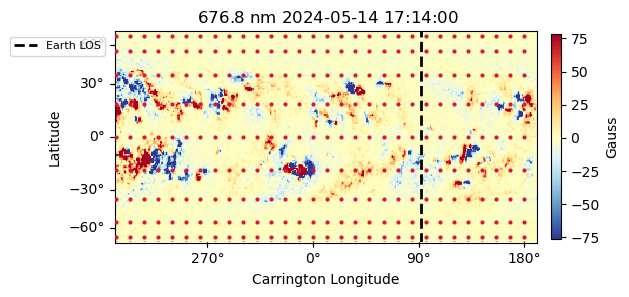

In [7]:
# find where is the Earth LOS on GONG map
hp_lon = 0*u.arcsec
hp_lat = np.linspace(-90, 90, 1)*u.arcsec

# Make a 2D grid from these 1D points
lon, lat  = np.meshgrid(hp_lon, hp_lat)
earth_los = SkyCoord(lon.ravel(), lat.ravel(), frame=gong_map.coordinate_frame)
los_lon   = sun.L0(time=gong_map.meta['date-obs']).value
print(f'Carrington longitude: {los_lon:.2f}')

fig = plt.figure()
ax  = plt.subplot(projection=gong_map)
gon = gong_map.plot(cmap='RdYlBu_r', clip_interval=[1, 99]*u.percent)

ax.plot_coord(seeds, color='crimson', marker='o', linewidth=0, markersize=2)
# ax.plot_coord(earth_los, color='k', marker='*', linewidth=0, markersize=5, label='Earth LOS')
ax.axvline(x=los_lon, color='black', linestyle='--', linewidth=2, label='Earth LOS')

ax.legend(loc='upper right', prop={'size':8}, bbox_to_anchor=(-0.01, 1))
fig.colorbar(gon, fraction=0.023, pad=0.03, label=pfss_in.map.meta['bunit'])
fig.tight_layout()
plt.show()

/tmp/ipykernel_2175426/982301172.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu_r')  # gray, RdBu_r, RdYlBu_r, seismic, bwr for polarity
Plotting the field lines: 100%|████████████████████████████████████████████| 300/300 [00:02<00:00, 140.65it/s]


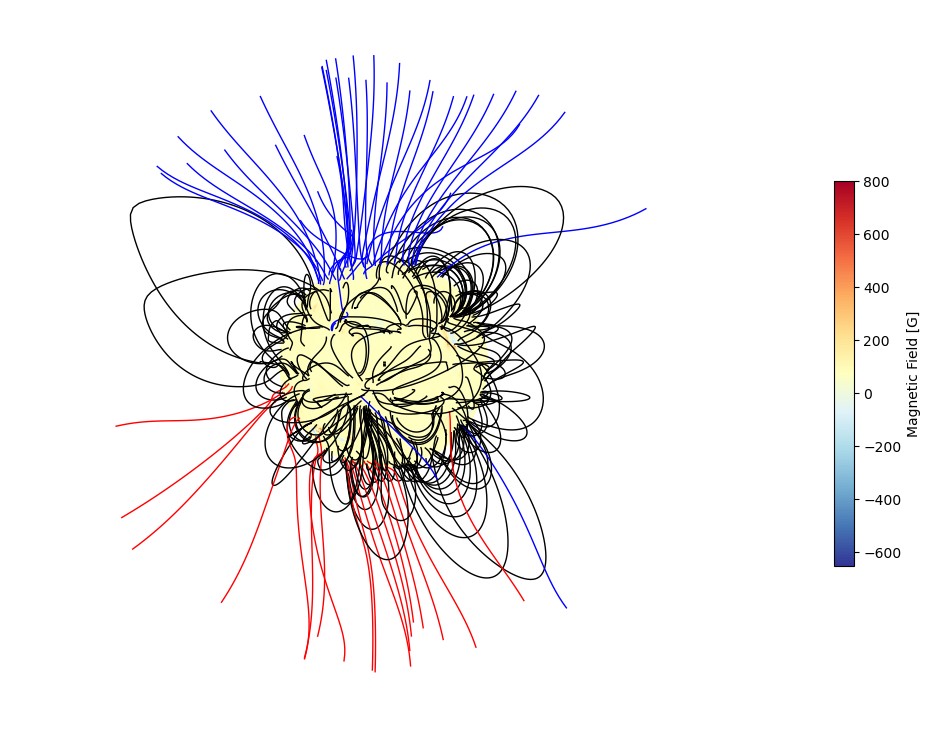

In [9]:
# Make the GONG sphere surface coordinates
theta, phi = np.mgrid[0:np.pi:180j, 0:2*np.pi:360j]
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

# Normalize the GONG data
gong_data = gong_map.data.astype(np.float32)
gong_data = np.nan_to_num(gong_data, nan=0.0)  # Remove NaNs

# Normalize for color mapping
abs_max = np.max(np.abs(gong_data))
normed_data = (gong_data + abs_max) / (2 * abs_max)

# Choose colormap (e.g., magnetogram style)
cmap = cm.get_cmap('RdYlBu_r')  # gray, RdBu_r, RdYlBu_r, seismic, bwr for polarity
colors = cmap(normed_data)

# If you’re using a diverging colormap (e.g. 'RdBu_r'), it’s better to center the normalization around 0
abs_max = np.max(np.abs(gong_data))
norm = Normalize(vmin=-abs_max, vmax=abs_max)
norm = Normalize(vmin=gong_data.min(), vmax=gong_data.max())

mappable = cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array([])  # Required dummy input

# Plot
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
ax.plot_surface(x, y, z, facecolors=colors, rstride=1, cstride=1, linewidth=0,
                    antialiased=False, shade=False, label='GONG')


# Convert Carrington (lon, lat) to spherical (theta, phi) for plotting
# phi   = longitude in radians: measured from x-axis
# theta = colatitude in radians: 0 at north pole → pi at south pole
phi = np.deg2rad(los_lon)
theta = np.pi / 2  # equator

ux = np.sin(theta) * np.cos(phi)
uy = np.sin(theta) * np.sin(phi)
uz = np.cos(theta)

# Shift starting point to 2 solar radii
start_r = 1.5
end_r   = 2  # arrow will be 0.5 R☉ long

x0, y0, z0 = start_r * ux, start_r * uy, start_r * uz
dx, dy, dz = (end_r - start_r) * ux, (end_r - start_r) * uy, (end_r - start_r) * uz

# Draw Earth LOS arrow
ax.quiver(x0, y0, z0, dx, dy, dz,
          color='k', arrow_length_ratio=0.2, linewidth=2, label='Earth LOS')

# Add colorbar
fig.colorbar(mappable, ax=ax, shrink=0.5, pad=0.1, label='Magnetic Field [G]')


# Add the PFSS lines
with tqdm(total=len(field_lines), desc='Plotting the field lines') as pbar:
    for n, field_line in enumerate(field_lines):
        color = {0:'black', -1:'blue', 1:'red'}.get(field_line.polarity)
        coords = field_line.coords
        coords.representation_type = 'cartesian'
        x_line = coords.x/const.radius
        y_line = coords.y/const.radius
        z_line = coords.z/const.radius
        ax.plot3D(x_line, y_line, z_line, alpha=1, color=color, linewidth=1, zorder=100)
        pbar.update(1)



# Plot config
fig_limit = 2
ax.set_xlim(-1*fig_limit, fig_limit)
ax.set_ylim(-1*fig_limit, fig_limit)
ax.set_zlim(-1*fig_limit, fig_limit)
ax.set_box_aspect([fig_limit, fig_limit, fig_limit])
ax.view_init(elev=0, azim=los_lon)
# ax.legend(title='Surfaces', loc='upper right', prop={'size':8}, bbox_to_anchor=(-0.01, 1))
ax.set_axis_off()
for axis in 'xyz':
    getattr(ax, 'set_{}label'.format(axis))(axis+' [R$_\odot]$')
fig.tight_layout()
plt.show()

## Slide controllers

In [19]:
plot_out = widgets.Output()

def plot_interactive_shell_plotly(n_lon_radial=30, n_lat_radial=30,
                                  radial_length=3,
                                  shell_lon_deg=90, shell_lat_deg=0,
                                  b_major=0.7, b_minor=0.7,
                                  shell_mesh_res=50,
                                  show_radials=False, show_normals=False,
                                  show_shell=False, show_field_lines=False,
                                  show_axes=True):
    
    with plot_out:
        plot_out.clear_output(wait=True)

        fig = go.Figure()
        
        # Create the Sun (sphere)
        theta, phi = np.mgrid[0:np.pi:50j, 0:2*np.pi:50j]
        x_sun = np.sin(theta) * np.cos(phi)
        y_sun = np.sin(theta) * np.sin(phi)
        z_sun = np.cos(theta)
        
        fig.add_trace(go.Surface(
            x=x_sun, y=y_sun, z=z_sun,
            colorscale=[[0, 'orange'], [1, 'orange']],
            showscale=False,
            name='Sun',
            hoverinfo='skip'
        ))
        
        # Convert shell center position to radians
        shell_lon = np.deg2rad(shell_lon_deg)
        shell_lat = np.deg2rad(shell_lat_deg)

        xshift = np.cos(shell_lat) * np.cos(shell_lon)
        yshift = np.cos(shell_lat) * np.sin(shell_lon)
        zshift = np.sin(shell_lat)

        # Create shell surface
        theta_src, phi_src = np.mgrid[0:np.pi:complex(shell_mesh_res), 0:2*np.pi:complex(shell_mesh_res)]
        x_src = xshift + b_minor * np.sin(theta_src) * np.cos(phi_src)
        y_src = yshift + b_minor * np.sin(theta_src) * np.sin(phi_src)
        z_src = zshift + b_major * np.cos(theta_src)

        r_shell = np.sqrt(x_src**2 + y_src**2 + z_src**2)
        mask = r_shell > 1
        x_outer = x_src[mask]
        y_outer = y_src[mask]
        z_outer = z_src[mask]

        # Calculate normal vectors
        a, b, c = b_minor, b_minor, b_major
        nx = 2 * (x_outer - xshift) / (a**2)
        ny = 2 * (y_outer - yshift) / (b**2)
        nz = 2 * (z_outer - zshift) / (c**2)
        norm = np.sqrt(nx**2 + ny**2 + nz**2)
        nx /= norm
        ny /= norm
        nz /= norm

        # Create display grid (with NaN inside the Sun)
        x_display = np.copy(x_src)
        y_display = np.copy(y_src)
        z_display = np.copy(z_src)
        r_display = np.sqrt(x_display**2 + y_display**2 + z_display**2)
        x_display[r_display < 1] = np.nan
        y_display[r_display < 1] = np.nan
        z_display[r_display < 1] = np.nan

        # Radial directions - always define for theta calculations
        all_points = []
        all_dirs = []

        if show_radials:
            theta_radial, phi_radial = np.mgrid[0:np.pi:complex(n_lat_radial), 0:2*np.pi:complex(n_lon_radial)]
            rdx = np.sin(theta_radial) * np.cos(phi_radial)
            rdy = np.sin(theta_radial) * np.sin(phi_radial)
            rdz = np.cos(theta_radial)
            rdx_flat = rdx.flatten()
            rdy_flat = rdy.flatten()
            rdz_flat = rdz.flatten()
            
            for i in range(len(rdx_flat)):
                r_vec = np.array([rdx_flat[i], rdy_flat[i], rdz_flat[i]])
                r_pts = np.linspace(0, radial_length, 50)
                lx = r_pts * r_vec[0]
                ly = r_pts * r_vec[1]
                lz = r_pts * r_vec[2]
                
                fig.add_trace(go.Scatter3d(
                    x=lx, y=ly, z=lz,
                    mode='lines',
                    line=dict(color='gray', width=2),
                    showlegend=False,
                    hoverinfo='skip',
                    opacity=0.3
                ))
                
                # Store points and directions for theta calculation
                for j in range(len(r_pts)-1):
                    all_points.append([lx[j], ly[j], lz[j]])
                    all_dirs.append(r_vec)
            
            all_points = np.array(all_points)
            all_dirs = np.array(all_dirs)

        
        # Plot the magnetic field lines (placeholder - you'll need to add your field_lines data)
        if show_field_lines:
            for n, field_line in enumerate(field_lines):
                color = {0:'black', -1:'blue', 1:'red'}.get(field_line.polarity)
                coords = field_line.coords
                coords.representation_type = 'cartesian'
                x_field = coords.x/const.radius
                y_field = coords.y/const.radius  
                z_field = coords.z/const.radius
                fig.add_trace(go.Scatter3d(
                    x=x_field, y=y_field, z=z_field,
                    mode='lines',
                    line=dict(color=color, width=2),
                    showlegend=False
                ))
    
            # Calculate theta angles between normal vectors and magnetic field lines
            # First, we need the field_lines data, and const.radius is the solar radius unit
            
            # Calculate field direction vectors (tangent to field line)
            for i in range(len(x_field)-1):
                # Field point
                field_point = np.array([x_field[i], y_field[i], z_field[i]])
                all_points.append(field_point)
    
                # Field direction (tangent vector)
                field_vector = np.array([x_field[i+1] - x_field[i], 
                                        y_field[i+1] - y_field[i], 
                                        z_field[i+1] - z_field[i]])
                # Normalize field vector
                field_vector = field_vector / np.linalg.norm(field_vector)
                all_dirs.append(field_vector)
    
            # Convert to arrays for downstream use
            all_points = np.array(all_points)
            all_dirs   = np.array(all_dirs)

        
        # Calculate theta angles between normal vectors and radial directions
        theta_angles = np.zeros_like(x_outer)
        
        if len(all_points) > 0:
            for i, (x_pt, y_pt, z_pt) in enumerate(zip(x_outer, y_outer, z_outer)):
                surf_pt = np.array([x_pt, y_pt, z_pt])
                dists = np.linalg.norm(all_points - surf_pt, axis=1)
                idx = np.argmin(dists)
                radial_dir = all_dirs[idx]
                n_vec = np.array([nx[i], ny[i], nz[i]])
                cos_theta = np.dot(n_vec, radial_dir)
                cos_theta = np.clip(cos_theta, -1.0, 1.0)
                theta_angles[i] = np.degrees(np.arccos(np.abs(cos_theta)))
        else:
            theta_angles[:] = np.nan

        # Map theta to surface
        theta_surface = np.full_like(x_src, np.nan)
        valid = np.where(mask)
        for i, (r_idx, c_idx) in enumerate(zip(*valid)):
            theta_surface[r_idx, c_idx] = theta_angles[i]
        
        # Show shell with theta angle coloring
        if show_shell:
            # Add shell center marker
            fig.add_trace(go.Scatter3d(
                x=[xshift], y=[yshift], z=[zshift],
                mode='markers',
                marker=dict(size=8, color='black'),
                showlegend=False,
                name='Shell Center'
            ))
            
            # Add shell surface with theta coloring
            fig.add_trace(go.Surface(
                x=x_display, y=y_display, z=z_display,
                surfacecolor=theta_surface,
                colorscale='Viridis',
                cmin=0, cmax=90,
                opacity=1,
                showscale=True,
                colorbar=dict(
                    title=dict(text='Theta Angle (degrees)', side='right'),
                    len=0.6
                ),
                name='Shell'
            ))
        
        
        # Show normal vectors
        if show_normals:
            # Sample normals to avoid too many arrows
            step = max(1, len(x_outer) // 100)  # Show max 100 arrows
            x_norm_sample = x_outer[::step]
            y_norm_sample = y_outer[::step]  
            z_norm_sample = z_outer[::step]
            nx_sample = nx[::step] * 0.2
            ny_sample = ny[::step] * 0.2
            nz_sample = nz[::step] * 0.2
            
            # Create line segments for normal vectors
            x_lines = []
            y_lines = []
            z_lines = []
            
            for i in range(len(x_norm_sample)):
                x_lines.extend([x_norm_sample[i], x_norm_sample[i] + nx_sample[i], None])
                y_lines.extend([y_norm_sample[i], y_norm_sample[i] + ny_sample[i], None])
                z_lines.extend([z_norm_sample[i], z_norm_sample[i] + nz_sample[i], None])
            
            fig.add_trace(go.Scatter3d(
                x=x_lines,
                y=y_lines,
                z=z_lines,
                mode='lines',
                line=dict(color='black', width=3),
                showlegend=False,
                name='Normal Vectors'
            ))

        
        # Layout settings
        fig.update_layout(
            scene=dict(
                xaxis=dict(range=[-2, 2], visible=show_axes),
                yaxis=dict(range=[-2, 2], visible=show_axes),
                zaxis=dict(range=[-2, 2], visible=show_axes),
                aspectmode='cube',
                camera=dict(
                    eye=dict(x=1.5, y=1.5, z=1.5)
                )
            ),
            width=1024,
            height=768,
            title='Interactive 3D Solar Shell Visualization',
            showlegend=False
        )
        
        fig.show()


# Create interactive widgets
wide_slider_layout = widgets.Layout(width='800px')

# Create sliders
slider_kwargs = dict(
    n_lon_radial=widgets.IntSlider(value=30, min=1, max=60, step=1, description='Radials (lon)', layout=wide_slider_layout),
    n_lat_radial=widgets.IntSlider(value=30, min=1, max=60, step=1, description='Radials (lat)', layout=wide_slider_layout),
    radial_length=widgets.FloatSlider(value=3, min=1, max=5, step=0.1, description='Radial length', layout=wide_slider_layout),
    shell_lon_deg=widgets.IntSlider(value=90, min=-180, max=180, step=5, description='Shell lon', layout=wide_slider_layout),
    shell_lat_deg=widgets.IntSlider(value=0, min=-90, max=90, step=5, description='Shell lat', layout=wide_slider_layout),
    b_major=widgets.FloatSlider(value=0.7, min=0.3, max=2.0, step=0.1, description='Shell major', layout=wide_slider_layout),
    b_minor=widgets.FloatSlider(value=0.7, min=0.3, max=2.0, step=0.1, description='Shell minor', layout=wide_slider_layout),
    shell_mesh_res=widgets.IntSlider(value=50, min=10, max=200, step=5, description='Shell mesh', layout=wide_slider_layout),
)

# Define checkboxes
checkbox_layout = widgets.Layout(width='160px', margin='0 5px 0 0')
cb_show_radials = widgets.Checkbox(value=False, description='Lines', layout=checkbox_layout)
cb_show_shell = widgets.Checkbox(value=False, description='Shell', layout=checkbox_layout)
cb_show_normals = widgets.Checkbox(value=False, description='Normals', layout=checkbox_layout)
cb_show_field_lines = widgets.Checkbox(value=False, description='PFSS', layout=checkbox_layout)
cb_show_axes = widgets.Checkbox(value=True, description='Axes', layout=checkbox_layout)

checkboxes_box = widgets.HBox([cb_show_radials, cb_show_shell, cb_show_normals, cb_show_field_lines, cb_show_axes])

# Create the interactive interface
ui = widgets.VBox([
    widgets.VBox(list(slider_kwargs.values())),
    checkboxes_box
])

def update_plot(**kwargs):
    with plot_out:
        plot_out.clear_output(wait=True)
        plot_interactive_shell_plotly(**kwargs)

controls = widgets.interactive(update_plot,
    **slider_kwargs,
    show_radials=cb_show_radials,
    show_shell=cb_show_shell,
    show_normals=cb_show_normals,
    show_field_lines=cb_show_field_lines,
    show_axes=cb_show_axes
)

display(ui, plot_out)

Output()

## Load AIA EUV data and make running-difference images

In [ ]:
channel     = 193
target_date = '2011_06_07'
data_type   = 'highres'

files = sorted(f for f in glob.glob(f'{data_dir}/AIA/{channel}A/{data_type}/lv1/*.fits') if target_date in f and str(channel) in f)
os.makedirs(f'{data_dir}/AIA/{channel}A/{data_type}/lv15', exist_ok=True)

aia_maps = []
for i, file in enumerate(files):
    output_filename = file.split('/')[-1].replace('lev1', 'lev15')
    
    file_path = f'{data_dir}/AIA/{channel}A/{data_type}/lv15/{output_filename}'
    
    if not os.path.exists(file_path):
        # load the file as a sunpy map
        m = sunpy.map.Map(file)
        print(f'AIA {channel}A map {i} is loaded ..')
        # update the metadata of the map to the most recent pointing
        m_updated = update_pointing(m)
        # scale the image to the 0.6"/pix
        # and derotate the image such that the y-axis is aligned with solar North
        m_registered = register(m_updated)
        # exposure time normalization
        m_normalized = m_registered / m_registered.exposure_time
        # export the calibrated map
        m_normalized.save(file_path, filetype='auto')
        print(f'Map {i} is exported')
        aia_maps.append(m_normalized)
    else:
        print(f'Map {i} exists already')

AIA 193A map 0 is loaded ..


2025-06-23 19:16:47 - astropy - WARNING: VerifyWarning: Invalid 'BLANK' keyword in header.  The 'BLANK' keyword is only applicable to integer data, and will be ignored in this HDU.


Map 0 is exported
AIA 193A map 1 is loaded ..


2025-06-23 19:16:56 - astropy - WARNING: VerifyWarning: Invalid 'BLANK' keyword in header.  The 'BLANK' keyword is only applicable to integer data, and will be ignored in this HDU.


Map 1 is exported
Map 2 exists already
AIA 193A map 3 is loaded ..


2025-06-23 19:17:05 - astropy - WARNING: VerifyWarning: Invalid 'BLANK' keyword in header.  The 'BLANK' keyword is only applicable to integer data, and will be ignored in this HDU.


Map 3 is exported
AIA 193A map 4 is loaded ..


2025-06-23 19:17:14 - astropy - WARNING: VerifyWarning: Invalid 'BLANK' keyword in header.  The 'BLANK' keyword is only applicable to integer data, and will be ignored in this HDU.


Map 4 is exported
AIA 193A map 5 is loaded ..


2025-06-23 19:17:23 - astropy - WARNING: VerifyWarning: Invalid 'BLANK' keyword in header.  The 'BLANK' keyword is only applicable to integer data, and will be ignored in this HDU.


Map 5 is exported
AIA 193A map 6 is loaded ..


2025-06-23 19:17:32 - astropy - WARNING: VerifyWarning: Invalid 'BLANK' keyword in header.  The 'BLANK' keyword is only applicable to integer data, and will be ignored in this HDU.


Map 6 is exported
AIA 193A map 7 is loaded ..


2025-06-23 19:17:42 - astropy - WARNING: VerifyWarning: Invalid 'BLANK' keyword in header.  The 'BLANK' keyword is only applicable to integer data, and will be ignored in this HDU.


Map 7 is exported
AIA 193A map 8 is loaded ..


2025-06-23 19:17:51 - astropy - WARNING: VerifyWarning: Invalid 'BLANK' keyword in header.  The 'BLANK' keyword is only applicable to integer data, and will be ignored in this HDU.


Map 8 is exported
AIA 193A map 9 is loaded ..


2025-06-23 19:18:00 - astropy - WARNING: VerifyWarning: Invalid 'BLANK' keyword in header.  The 'BLANK' keyword is only applicable to integer data, and will be ignored in this HDU.


Map 9 is exported
AIA 193A map 10 is loaded ..


2025-06-23 19:18:09 - astropy - WARNING: VerifyWarning: Invalid 'BLANK' keyword in header.  The 'BLANK' keyword is only applicable to integer data, and will be ignored in this HDU.


Map 10 is exported
AIA 193A map 11 is loaded ..


2025-06-23 19:18:18 - astropy - WARNING: VerifyWarning: Invalid 'BLANK' keyword in header.  The 'BLANK' keyword is only applicable to integer data, and will be ignored in this HDU.


Map 11 is exported
AIA 193A map 12 is loaded ..


2025-06-23 19:18:27 - astropy - WARNING: VerifyWarning: Invalid 'BLANK' keyword in header.  The 'BLANK' keyword is only applicable to integer data, and will be ignored in this HDU.


Map 12 is exported
AIA 193A map 13 is loaded ..


2025-06-23 19:18:36 - astropy - WARNING: VerifyWarning: Invalid 'BLANK' keyword in header.  The 'BLANK' keyword is only applicable to integer data, and will be ignored in this HDU.


Map 13 is exported
AIA 193A map 14 is loaded ..


### Apply running-ratio and normalization

In [ ]:
runratio = [m / prev_m.quantity for m, prev_m in zip(aia_maps[1:], aia_maps[:-1])]
m_seq_runratio = sunpy.map.Map(runratio, sequence=True)

for m in m_seq_runratio:
    m.data[np.isnan(m.data)] = 1
    m.plot_settings['cmap'] = 'Greys_r'
    m.plot_settings['norm'] = colors.Normalize(vmin=0, vmax=2)